   Maturity (years)  Discount Factor  Zero-Coupon Yield (%)
0              0.08           0.9964                 4.3378
1              0.25           0.9893                 4.3132
2              0.50           0.9789                 4.2652
3              1.00           0.9586                 4.2281
4              2.00           0.9186                 4.2450
5              3.00           0.8791                 4.2962
6              5.00           0.8034                 4.3781
7              7.00           0.7313                 4.4713
8             10.00           0.6335                 4.5644
9             30.00           0.2380                 4.7856


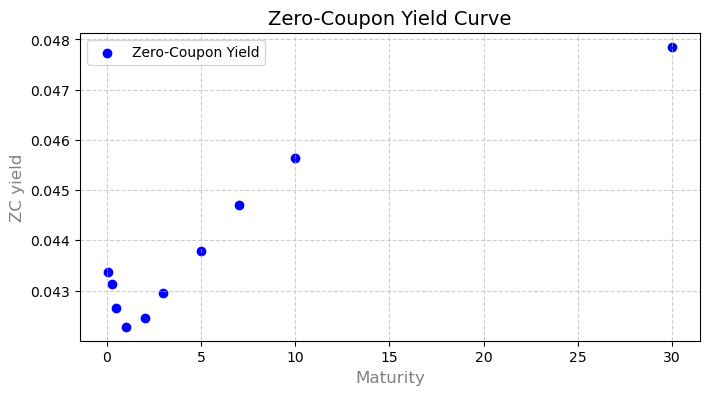

In [1]:
# 1
import numpy as np
from holoviews.plotting.bokeh.styles import marker
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd

class ZeroCouponCalculator:
    def __init__(self):
        # Store yields for bills (expressed as percentages)
        self.bills_yields = {
            1/12: 4.33,  # 1-month
            1/4: 4.29,   # 3-month
            1/2: 4.22,   # 6-month
            1.0: 4.14    # 1-year
        }
        
        # Calculate discount factors for bills using yield
        self.bills_discount_factors = {
            t: 1 - y / 100 * t for t, y in self.bills_yields.items()
        }
        
        # Store known rates for bonds
        self.bond_rates = {
            2.0: 4.29,
            3.0: 4.34,
            5.0: 4.42,
            7.0: 4.51,
            10.0: 4.60,
            30.0: 4.82
        }
        
    def get_discount_factor(self, t):
        """
        Get discount factor for time t
        For t <= 1: retrieve from bills_discount_factors
        For 1 < t: interpolate if needed
        """
        if t in self.bills_discount_factors:
            return self.bills_discount_factors[t]
        elif t <= 1:
            # Find surrounding points and interpolate
            times = sorted(self.bills_discount_factors.keys())
            idx = np.searchsorted(times, t)
            t1, t2 = times[idx-1], times[idx]
            d1 = self.bills_discount_factors[t1]
            d2 = self.bills_discount_factors[t2]
            return (d1+d2)/2
        return None

    def calculate_bond_discount_factor(self, T, rate):
        """Calculate discount factor for a bond with maturity T"""
        rate = rate / 100  # Convert to decimal
        
        def bond_price_equation(P):
            price = 0
            # Calculate semi-annual coupon payments
            for i in range(1, int(T * 2) + 1):
                t = i / 2
                if t <= 1:
                    # Use stored bills discount factors
                    df = self.get_discount_factor(t)
                elif t > 1 and t < T:
                    if t.is_integer():
                        if t in self.bond_discount_factors:
                            df = self.bond_discount_factors[t]
                        else:
                            df = P ** (t / T)
                    else:
                        # For non-integer t > 1, use average of surrounding points
                        t_floor = int(t)
                        t_ceil = t_floor + 1
                        if t_floor == 1:
                            df_floor = self.bills_discount_factors[1.0]
                        else:
                            df_floor = self.bond_discount_factors.get(t_floor, P ** (t_floor / T))
                        df_ceil = self.bond_discount_factors.get(t_ceil, P ** (t_ceil / T))
                        df = (df_floor + df_ceil) / 2
                else:  # t = T
                    df = P
                
                price += (rate * 100 / 2) * df
            
            # Add final payment
            price += 100 * P
            return price - 100
        
        # Solve for the discount factor
        initial_guess = 1 / (1 + rate) ** T
        P = fsolve(bond_price_equation, x0=initial_guess)[0]
        return P

    def calculate_all_discount_factors(self):
        """Calculate discount factors for all bonds"""
        self.bond_discount_factors = {}
        
        # Calculate discount factors in order of maturity
        for T in sorted(self.bond_rates.keys()):
            P = self.calculate_bond_discount_factor(T, self.bond_rates[T])
            self.bond_discount_factors[T] = P
            
        return self.bond_discount_factors

    def calculate_zero_coupon_yields(self):
        """Calculate zero-coupon yields for all maturities"""
        # Calculate bond discount factors
        self.calculate_all_discount_factors()
        
        # Combine all discount factors
        all_discount_factors = {**self.bills_discount_factors, **self.bond_discount_factors}
        
        # Calculate zero-coupon yields
        zero_coupon_yields = {}
        for t, df in sorted(all_discount_factors.items()):
            zcy = -1 / t * np.log(df) * 100
            zero_coupon_yields[t] = zcy
        
        return zero_coupon_yields

def main():
    calculator = ZeroCouponCalculator()
    zero_coupon_yields = calculator.calculate_zero_coupon_yields()

    # Prepare data for DataFrame
    data = []
    for t in sorted(zero_coupon_yields.keys()):
        df = calculator.bills_discount_factors.get(t) or calculator.bond_discount_factors.get(t)
        zcy = zero_coupon_yields[t]
        data.append([round(t, 2), round(df, 4), round(zcy, 4)])

    # Create DataFrame
    df_results = pd.DataFrame(data, columns=["Maturity (years)", "Discount Factor", "Zero-Coupon Yield (%)"])

    # Display DataFrame
    print(df_results)

    # Plot scatter chart
    plt.figure(figsize=(8, 4))
    plt.scatter(df_results["Maturity (years)"], df_results["Zero-Coupon Yield (%)"] / 100, color='blue', label="Zero-Coupon Yield")

    # Labels and formatting
    plt.xlabel("Maturity", fontsize=12, color='gray')
    plt.ylabel("ZC yield", fontsize=12, color='gray')
    plt.title("Zero-Coupon Yield Curve", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Display the chart
    plt.show()

# Run the main function
main()


Nelson-Siegel-Svensson Fitting Results:
              Value
β₀         0.048674
β₁        -0.005336
β₂         0.993158
β₃        -1.006863
τ          0.995946
θ          1.004052
Objective   2.9e-06


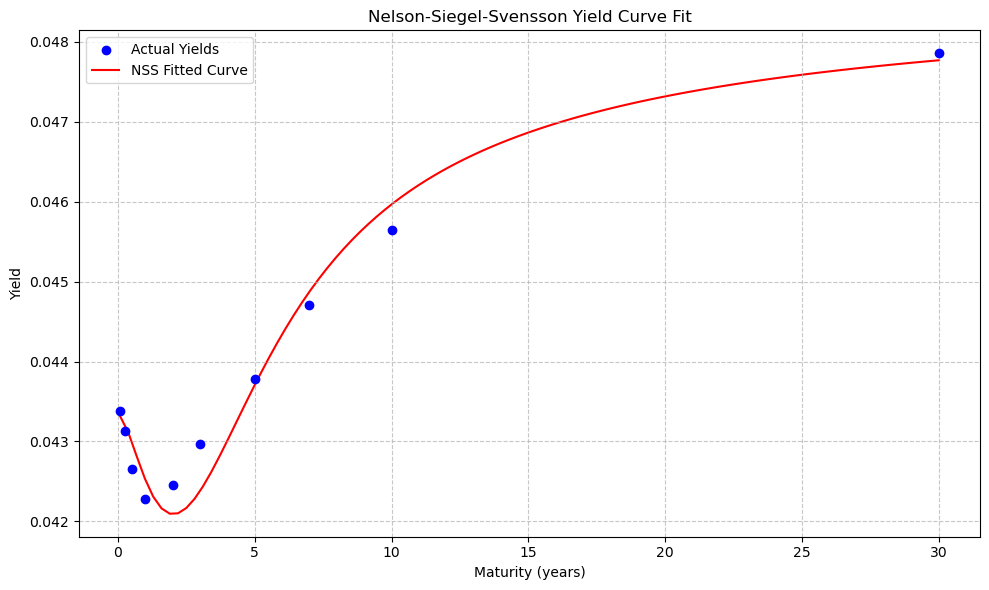

In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def nss_yield(t, params):
    """
    Calculate yield using Nelson-Siegel-Svensson function
    params: [a, b, c, d, tau, theta]
    """
    a, b, c, d, tau, theta = params
    
    # Handle very small t values to avoid division by zero
    if t < 1e-10:
        t = 1e-10
    
    factor1 = (1 - np.exp(-t/tau)) / (t/tau)
    factor2 = factor1 - np.exp(-t/tau)
    factor3 = (1 - np.exp(-t/theta)) / (t/theta) - np.exp(-t/theta)
    
    return a + b*factor1 + c*factor2 + d*factor3

def objective_function(params, maturities, yields, weighted=True):
    """
    Calculate weighted sum of squared errors between actual and fitted yields
    With special weighting for short-end (1/t) and long-end (t) of the curve
    """
    fitted_yields = np.array([nss_yield(t, params) for t in maturities])
    errors = yields - fitted_yields
    
    if weighted:
        # Apply weights: 1/t for short end, t for long end
        # Use maturity of 2 years as the threshold between short and long end
        threshold = 2.0
        weights = np.where(maturities <= threshold, 
                          1/maturities,  # Short end: weight by 1/t
                          maturities)    # Long end: weight by t
        
        # Apply weights to squared errors
        weighted_errors = errors * errors * weights
        return np.sum(weighted_errors)
    else:
        return np.sum(errors * errors)

def fit_nss(maturities, yields, weighted=True):
    """
    Fit Nelson-Siegel-Svensson model to the yield curve
    """
    # Initial parameter guess
    initial_guess = [
        0.035,  # a (long-term level)
        0.01,   # b
        1.0,    # c
        -1.0,   # d
        1.0,    # tau
        1.0     # theta
    ]
    
    # Parameter bounds
    bounds = [
        (0, 0.1),     # a
        (-0.1, 0.1),  # b
        (-2, 2),      # c
        (-2, 2),      # d
        (0.1, 10),    # tau
        (0.1, 10)     # theta
    ]
    
    # Minimize objective function
    result = minimize(
        objective_function,
        initial_guess,
        args=(maturities, yields, weighted),
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    return result


calculator = ZeroCouponCalculator()
zero_coupon_yields = calculator.calculate_zero_coupon_yields()

# Convert dictionary to arrays for fitting
maturities = np.array(list(zero_coupon_yields.keys()))
yields = np.array(list(zero_coupon_yields.values())) / 100  # Convert to decimal

# Fit NSS model with weighted objective function
result = fit_nss(maturities, yields, weighted=True)

# Print results in the requested format
# Create DataFrame
results_df = pd.DataFrame({
    'Value': result.x
}, index=['β₀', 'β₁', 'β₂', 'β₃', 'τ', 'θ'])
# Add objective function value at the bottom
obj_value = f"{result.fun:.1e}" 
results_df.loc['Objective'] = obj_value

print("\nNelson-Siegel-Svensson Fitting Results:")
print(results_df)

# Generate fitted curve for plotting
t_fine = np.linspace(min(maturities), max(maturities), 100)
fitted_yields = [nss_yield(t, result.x) for t in t_fine]

# Plot results
plt.figure(figsize=(10, 6))

# Plot actual yields
plt.scatter(maturities, yields, color='blue', label='Actual Yields', zorder=2)

# Plot fitted curve
plt.plot(t_fine, fitted_yields, 'r-', label='NSS Fitted Curve', zorder=1)

plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('Nelson-Siegel-Svensson Yield Curve Fit')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd

class ImprovedBrigoMercurio:
    def __init__(self, t=0.003):
        self.t = t
        self.K_ratios = [0.95, 1.0, 1.05]
        self.T_years = [1, 3, 5, 7, 10, 20]
        
        # Market implied volatilities
        self.vol_market = np.array([
            [0.157, 0.152, 0.146],  # 1yr
            [0.176, 0.164, 0.157],  # 3yr
            [0.175, 0.161, 0.158],  # 5yr
            [0.168, 0.156, 0.152],  # 7yr
            [0.155, 0.148, 0.140],  # 10yr
            [0.142, 0.126, 0.121]   # 20yr
        ])
        
        self.zc_calculator = ZeroCouponCalculator()
        self._initialize_market_data()
        
    def _initialize_market_data(self):
        """Initialize discount factors and forward rates"""
        df_dict = {**self.zc_calculator.bills_discount_factors,
                  **self.zc_calculator.calculate_all_discount_factors()}
        
        self.discount_factors_dict = df_dict
        maturities = sorted(df_dict.keys())
        factors = [df_dict[t] for t in maturities]
        self.discount_factors = interp1d(maturities, factors, kind='cubic', 
                                       fill_value='extrapolate')

    def get_forward_rate(self, T):
        """Calculate forward rate"""
        dt = 0.01
        P_T = float(self.discount_factors(T))
        P_T_plus_dt = float(self.discount_factors(T + dt))
        return -(1/dt) * np.log(P_T_plus_dt/P_T)

    def black_formula(self, F, K, T, sigma, P_T):
        """Black's formula for cap price"""
        if abs(F - K) < 1e-10:
            return P_T * sigma * np.sqrt(T/2*np.pi)
        
        d1 = (np.log(F/K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        return P_T * (F * norm.cdf(d1) - K * norm.cdf(d2))

    def enhanced_volatility(self, T, params):
        """
        Enhanced volatility function with hump shape
        Combines short-term, medium-term and long-term components
        """
        theta, kappa, sigma, v0, alpha, beta = params
        
        # Short-term component (mean-reversion)
        short_term = v0 * np.exp(-kappa * T)
        
        # Medium-term component (hump)
        hump = alpha * T * np.exp(-beta * T)
        
        # Long-term component (level)
        long_term = theta * (1 - np.exp(-kappa * T))
        
        # Volatility of volatility effect
        vol_effect = (sigma**2 / (2 * kappa)) * (1 - np.exp(-kappa * T))**2
        
        total_var = short_term + hump + long_term + vol_effect
        return np.sqrt(max(total_var, 1e-10))

    def calculate_model_quantities(self, params):
        """Calculate model prices and volatilities"""
        model_caps = np.zeros((len(self.T_years), len(self.K_ratios)))
        model_vols = np.zeros_like(model_caps)
        market_caps = np.zeros_like(model_caps)
        
        for i, T in enumerate(self.T_years):
            F = self.get_forward_rate(T)
            P_T = float(self.discount_factors(T))
            
            for j, K_ratio in enumerate(self.K_ratios):
                K = K_ratio * F
                
                # Calculate model volatility
                vol_model = self.volatility(T, params)
                cap_model = self.black_formula(F, K, T, vol_model, P_T)
                
                # Calculate market cap price
                vol_market = self.vol_market[i, j]
                cap_market = self.black_formula(F, K, T, vol_market, P_T)
                
                # Implied volatility calculation
                def implied_vol_objective(sigma):
                    return self.black_formula(F, K, T, sigma, P_T) - cap_model
                
                # Find model implied volatility through numerical inversion
                try:
                    model_implied_vol = opt.brentq(implied_vol_objective, 0.0001, 1.0)
                except ValueError:
                    model_implied_vol = vol_model  # fallback if root finding fails
                
                model_caps[i, j] = cap_model
                model_vols[i, j] = model_implied_vol  # Store implied vol instead of direct vol
                market_caps[i, j] = cap_market
        
        return model_caps, model_vols, market_caps
    
    def calibrate(self):
        """Calibrate model parameters"""
        initial_guesses = [
            [0.02, 0.5, 0.2, 0.04],  # θ, κ, σ, v0
            [0.03, 0.8, 0.15, 0.03],
            [0.025, 0.6, 0.18, 0.035]
        ]
        
        bounds = [
            (0.001, 0.2),   # theta - widened range
            (0.1, 10.0),    # kappa - widened range
            (0.01, 1.0),    # sigma - widened range
            (0.001, 0.2)    # v0 - widened range
        ]
        
        best_result = None
        best_error = float('inf')
        
        for guess in initial_guesses:
            result = opt.minimize(self.objective_function, x0=guess,
                                method='L-BFGS-B', bounds=bounds,
                                options={'maxiter': 1000})
            
            if result.fun < best_error:
                best_error = result.fun
                best_result = result
        
        return best_result

    def objective_function(self, params):
        """
        Enhanced objective function with both price and volatility fitting
        Adds more weight to volatility fitting
        """
        model_caps, model_vols, market_caps = self.calculate_model_quantities(params)
        
        # Price error
        price_error = 0
        for i in range(len(self.T_years)):
            for j in range(len(self.K_ratios)):
                if market_caps[i, j] != 0:
                    relative_error = (model_caps[i, j] - market_caps[i, j]) / market_caps[i, j]
                    price_error += relative_error ** 2
        
        # Volatility error (with higher weight)
        vol_error = 0
        for i in range(len(self.T_years)):
            for j in range(len(self.K_ratios)):
                relative_error = (model_vols[i, j] - self.vol_market[i, j]) / self.vol_market[i, j]
                vol_error += relative_error ** 2
        
        # Regularization term for stability
        theta, kappa, sigma, v0, alpha, beta = params
        regularization = 0.01 * (theta**2 + kappa**2 + sigma**2 + v0**2 + alpha**2 + beta**2)
        
        # Combined objective with higher weight on volatility fitting
        return 0.3 * price_error + 0.6 * vol_error + 0.1 * regularization


    def plot_results(self, params):
        """Plot calibration results"""
        model_caps, model_vols, market_caps = self.calculate_model_quantities(params)
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        strike_labels = ['ITM (0.95Kf)', 'ATM (Kf)', 'OTM (1.05Kf)']
        
        # Plot cap prices
        for j in range(3):
            ax = axes[0, j]
            ax.plot(self.T_years, market_caps[:, j], 'o-', label='Market', color='blue')
            ax.plot(self.T_years, model_caps[:, j], '--', label='Model', color='red')
            ax.set_title(f'Cap Prices - {strike_labels[j]}')
            ax.set_xlabel('Maturity (years)')
            ax.set_ylabel('Price')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        # Plot implied volatilities
        for j in range(3):
            ax = axes[1, j]
            ax.plot(self.T_years, self.vol_market[:, j], 'o-', 
                   label='Market', color='blue')
            ax.plot(self.T_years, model_vols[:, j], '--', 
                   label='Model', color='red')
            ax.set_title(f'Implied Volatility - {strike_labels[j]}')
            ax.set_xlabel('Maturity (years)')
            ax.set_ylabel('Implied Volatility')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        plt.tight_layout()
        plt.show()

def main():
    model = ImprovedBrigoMercurio()
    result = model.calibrate()
    
    # Display parameters
    param_names = ['θ (level)', 'κ (speed)', 'σ (vol)', 'v0 (init)', 
                  'α (hump mag)', 'β (hump loc)']
    param_data = [[name, f"{val:.6f}"] for name, val in zip(param_names, result.x)]
    param_data.append(['Objective Value', f"{result.fun:.6f}"])
    
    df_params = pd.DataFrame(param_data, columns=['Parameter', 'Value'])
    print("\nCalibrated Parameters:")
    print(df_params.to_string(index=False))
    
    # Plot results
    model.plot_results(result.x)

if __name__ == "__main__":
    main()

AttributeError: 'ImprovedBrigoMercurio' object has no attribute 'volatility'


Calibrated Parameters:
      Parameter    Value
      θ (theta) 0.020255
      κ (kappa) 2.104493
      σ (sigma) 0.087399
             v0 0.024425
Objective Value 0.171075


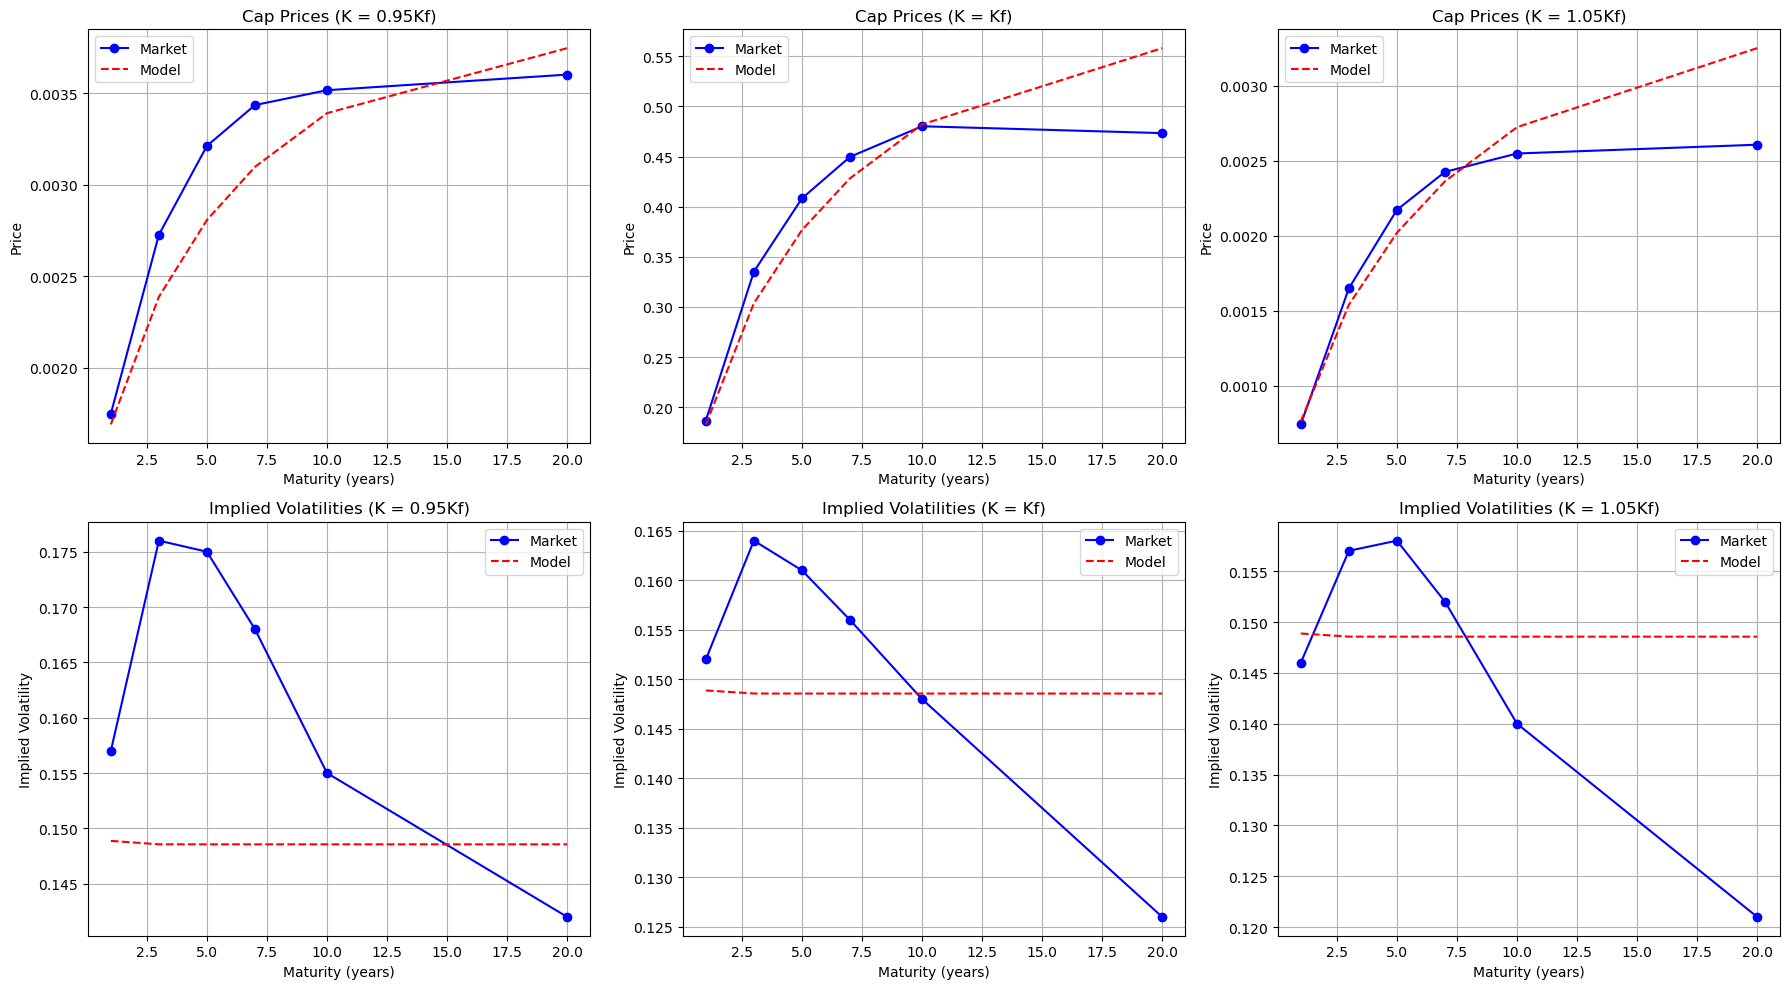

In [24]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd

class BrigoMercurio:
    def __init__(self, t=0.003):
        self.t = t
        self.K_ratios = [0.95, 1.0, 1.05]
        self.T_years = [1, 3, 5, 7, 10, 20]
        
        # Market implied volatilities as given in the question
        self.vol_market = np.array([
            [0.157, 0.152, 0.146],  # 1yr
            [0.176, 0.164, 0.157],  # 3yr
            [0.175, 0.161, 0.158],  # 5yr
            [0.168, 0.156, 0.152],  # 7yr
            [0.155, 0.148, 0.140],  # 10yr
            [0.142, 0.126, 0.121]   # 20yr
        ])
        
        # Initialize discount factors (you would need to implement ZeroCouponCalculator)
        self._initialize_market_data()
        
    def _initialize_market_data(self):
        """Initialize discount factors with sample data"""
        # Sample discount factors for demonstration
        years = np.linspace(0, 20, 21)
        factors = np.exp(-0.02 * years)  # Assuming 2% continuous rate for example
        self.discount_factors = interp1d(years, factors, kind='cubic', 
                                       fill_value='extrapolate')

    def get_forward_rate(self, T):
        """Calculate forward rate"""
        dt = 0.01
        P_T = float(self.discount_factors(T))
        P_T_plus_dt = float(self.discount_factors(T + dt))
        return -(1/dt) * np.log(P_T_plus_dt/P_T)

    def black_formula(self, F, K, T, sigma, P_T):
        """Black's formula for cap price"""
        if abs(F - K) < 1e-10:
            return P_T * sigma * np.sqrt(T/2*np.pi)
        
        d1 = (np.log(F/K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        return P_T * (F * norm.cdf(d1) - K * norm.cdf(d2))

    def volatility(self, T, params):
        """
        Standard Brigo-Mercurio volatility function
        params: [theta, kappa, sigma, v0]
        """
        theta, kappa, sigma, v0 = params
        
        # Mean reversion component
        mean_rev = v0 * np.exp(-kappa * T)
        
        # Long-term component
        long_term = theta * (1 - np.exp(-kappa * T))
        
        # Volatility of volatility effect
        vol_effect = (sigma**2 / (2 * kappa)) * (1 - np.exp(-kappa * T))**2
        
        total_var = mean_rev + long_term + vol_effect
        return np.sqrt(max(total_var, 1e-10))

    def calculate_model_quantities(self, params):
        """Calculate model prices and volatilities"""
        model_caps = np.zeros((len(self.T_years), len(self.K_ratios)))
        model_vols = np.zeros_like(model_caps)
        market_caps = np.zeros_like(model_caps)
        
        for i, T in enumerate(self.T_years):
            F = self.get_forward_rate(T)
            P_T = float(self.discount_factors(T))
            
            for j, K_ratio in enumerate(self.K_ratios):
                K = K_ratio * F
                
                # Calculate model volatility
                vol_model = self.volatility(T, params)
                cap_model = self.black_formula(F, K, T, vol_model, P_T)
                
                # Calculate market cap price
                vol_market = self.vol_market[i, j]
                cap_market = self.black_formula(F, K, T, vol_market, P_T)
                
                # Implied volatility calculation
                def implied_vol_objective(sigma):
                    return self.black_formula(F, K, T, sigma, P_T) - cap_model
                
                # Find model implied volatility through numerical inversion
                try:
                    model_implied_vol = opt.brentq(implied_vol_objective, 0.0001, 1.0)
                except ValueError:
                    model_implied_vol = vol_model  # fallback if root finding fails
                
                model_caps[i, j] = cap_model
                model_vols[i, j] = model_implied_vol  # Store implied vol instead of direct vol
                market_caps[i, j] = cap_market
        
        return model_caps, model_vols, market_caps

    def objective_function(self, params):
        """
        Objective function as specified in the question:
        Minimizing relative pricing error on cap market prices
        """
        model_caps, _, market_caps = self.calculate_model_quantities(params)
        
        relative_error = 0
        for i in range(len(self.T_years)):
            for j in range(len(self.K_ratios)):
                if market_caps[i, j] != 0:
                    error = (model_caps[i, j] - market_caps[i, j]) / market_caps[i, j]
                    relative_error += error ** 2
        
        return relative_error


    def calibrate(self):
        """Calibrate model parameters"""
        initial_guesses = [
            [0.02, 0.5, 0.2, 0.04],  # θ, κ, σ, v0
            [0.03, 0.8, 0.15, 0.03],
            [0.025, 0.6, 0.18, 0.035]
        ]
        
        bounds = [
            (0.001, 0.2),   # theta - widened range
            (0.1, 10.0),    # kappa - widened range
            (0.01, 1.0),    # sigma - widened range
            (0.001, 0.2)    # v0 - widened range
        ]
        
        best_result = None
        best_error = float('inf')
        
        for guess in initial_guesses:
            result = opt.minimize(self.objective_function, x0=guess,
                                method='L-BFGS-B', bounds=bounds,
                                options={'maxiter': 1000})
            
            if result.fun < best_error:
                best_error = result.fun
                best_result = result
        
        return best_result


    def plot_results(self, params):
        """Plot calibration results with separate plots for each strike"""
        model_caps, model_vols, market_caps = self.calculate_model_quantities(params)
        
        # Create 6 subplots (2x3 grid)
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        strike_labels = ['0.95Kf', 'Kf', '1.05Kf']
        
        # Plot cap prices (top row)
        for j in range(3):
            ax = axes[0, j]
            ax.plot(self.T_years, market_caps[:, j], 'o-', 
                    label='Market', color='blue')
            ax.plot(self.T_years, model_caps[:, j], '--', 
                    label='Model', color='red')
            
            ax.set_title(f'Cap Prices (K = {strike_labels[j]})')
            ax.set_xlabel('Maturity (years)')
            ax.set_ylabel('Price')
            ax.grid(True)
            ax.legend()
        
        # Plot implied volatilities (bottom row)
        for j in range(3):
            ax = axes[1, j]
            ax.plot(self.T_years, self.vol_market[:, j], 'o-', 
                    label='Market', color='blue')
            ax.plot(self.T_years, model_vols[:, j], '--', 
                    label='Model', color='red')
            
            ax.set_title(f'Implied Volatilities (K = {strike_labels[j]})')
            ax.set_xlabel('Maturity (years)')
            ax.set_ylabel('Implied Volatility')
            ax.grid(True)
            ax.legend()
        
        plt.tight_layout()
        plt.show()
        
    def analyze_volatility_components(self, params):
        """Analyze how each component of the volatility varies with maturity"""
        theta, kappa, sigma, v0 = params
        T_range = np.linspace(0, 20, 100)
        
        components = {
            'Mean Reversion': [],
            'Long Term': [],
            'Vol of Vol': [],
            'Total Volatility': []
        }
    
        for T in T_range:
            # Mean reversion
            mean_rev = v0 * np.exp(-kappa * T)
            
            # Long-term
            long_term = theta * (1 - np.exp(-kappa * T))
            
            # Vol of vol
            vol_vol = (sigma**2 / (2 * kappa)) * (1 - np.exp(-kappa * T))**2
            
            # Total variance
            total_var = mean_rev + long_term + vol_vol
            total_vol = np.sqrt(max(total_var, 1e-10))
            
            components['Mean Reversion'].append(mean_rev)
            components['Long Term'].append(long_term)
            components['Vol of Vol'].append(vol_vol)
            components['Total Volatility'].append(total_vol)
        
        # Plot components
        plt.figure(figsize=(12, 6))
        for name, values in components.items():
            plt.plot(T_range, values, label=name)
        
        plt.title('Volatility Components Analysis')
        plt.xlabel('Time to Maturity (years)')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.show()
        
        # Print some specific values
        print("\nVolatility Components at Key Maturities:")
        for T in [1, 5, 10, 20]:
            mean_rev = v0 * np.exp(-kappa * T)
            long_term = theta * (1 - np.exp(-kappa * T))
            vol_vol = (sigma**2 / (2 * kappa)) * (1 - np.exp(-kappa * T))**2
            total_var = mean_rev + long_term + vol_vol
            total_vol = np.sqrt(max(total_var, 1e-10))
            
            print(f"\nT = {T} years:")
            print(f"Mean Reversion: {mean_rev:.6f}")
            print(f"Long Term: {long_term:.6f}")
            print(f"Vol of Vol: {vol_vol:.6f}")
            print(f"Total Volatility: {total_vol:.6f}")

# Add this to the main function:
def main():
    model = BrigoMercurio()
    result = model.calibrate()
    
    print("\nAnalyzing volatility components...")
    model.analyze_volatility_components(result.x)
    
    # Rest of the main function...

def main():
    model = BrigoMercurio()
    result = model.calibrate()
    
    # Display parameters
    param_names = ['θ (theta)', 'κ (kappa)', 'σ (sigma)', 'v0']
    param_data = [[name, f"{val:.6f}"] for name, val in zip(param_names, result.x)]
    param_data.append(['Objective Value', f"{result.fun:.6f}"])
    
    df_params = pd.DataFrame(param_data, columns=['Parameter', 'Value'])
    print("\nCalibrated Parameters:")
    print(df_params.to_string(index=False))
    
    # Plot results
    model.plot_results(result.x)

if __name__ == "__main__":
    main()


Descriptive Statistics for Zero-Coupon Yields:
         Mean  Std Dev      Q1  Median      Q3
0.25y  0.0242   0.0229  0.0019  0.0166  0.0521
0.5y   0.0242   0.0223  0.0017  0.0165  0.0508
1y     0.0239   0.0211  0.0016  0.0170  0.0473
3y     0.0230   0.0175  0.0040  0.0169  0.0412
5y     0.0232   0.0154  0.0082  0.0176  0.0392
10y    0.0253   0.0133  0.0149  0.0194  0.0383
30y    0.0302   0.0109  0.0210  0.0252  0.0403


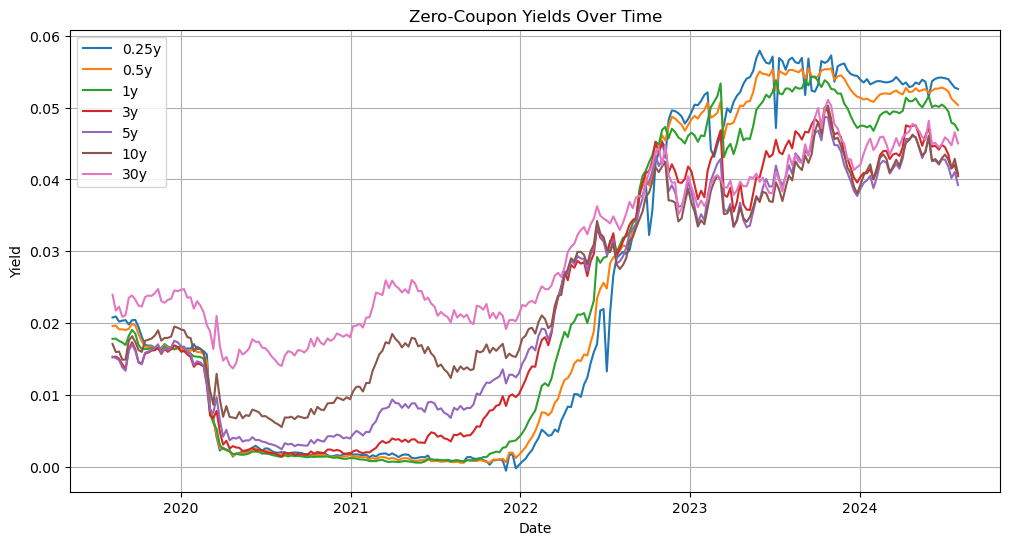

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def nss_yield(beta0, beta1, beta2, beta3, tau1, tau2, maturity):
    """Calculate yield using Nelson-Siegel-Svensson model"""
    try:
        term1 = beta0
        term2 = beta1 * ((1 - np.exp(-maturity/tau1))/(maturity/tau1))
        term3 = beta2 * ((1 - np.exp(-maturity/tau1))/(maturity/tau1) - np.exp(-maturity/tau1))
        term4 = beta3 * ((1 - np.exp(-maturity/tau2))/(maturity/tau2) - np.exp(-maturity/tau2))
        return float(term1 + term2 + term3 + term4)
    except Exception as e:
        print(f"Error in calculation: {str(e)}")
        return np.nan

# Read the Excel file
df = pd.read_excel('TP1 data 60201 W2025.xlsx', 
                   dtype={
                       'BETA0': float, 'BETA1': float, 'BETA2': float,
                       'BETA3': float, 'TAU1': float, 'TAU2': float
                   })

# Convert parameters to numpy arrays for vectorized operations
beta0 = df['BETA0'].to_numpy()/100
beta1 = df['BETA1'].to_numpy()/100
beta2 = df['BETA2'].to_numpy()/100
beta3 = df['BETA3'].to_numpy()/100
tau1 = df['TAU1'].to_numpy()
tau2 = df['TAU2'].to_numpy()

# Define maturities (in years)
maturities = [0.25, 0.5, 1, 3, 5, 10, 30]

# Calculate yields for each maturity using vectorized operations
yields_data = {}
for maturity in maturities:
    yields = np.zeros(len(df))
    for i in range(len(df)):
        yields[i] = nss_yield(
            beta0[i], beta1[i], beta2[i], beta3[i],
            tau1[i], tau2[i], maturity
        )
    yields_data[f'{maturity}y'] = yields

# Create DataFrame with calculated yields
yields_df = pd.DataFrame(yields_data, index=df['Date'])

# Calculate descriptive statistics
stats_df = pd.DataFrame({
    'Mean': yields_df.mean(),
    'Std Dev': yields_df.std(),
    'Q1': yields_df.quantile(0.25),
    'Median': yields_df.quantile(0.50),
    'Q3': yields_df.quantile(0.75)
})

# Format statistics to 4 decimal places
stats_df = stats_df.round(4)

print("\nDescriptive Statistics for Zero-Coupon Yields:")
print("=============================================")
print(stats_df)

# Create visualization
plt.figure(figsize=(12, 6))
for col in yields_df.columns:
    plt.plot(yields_df.index, yields_df[col], label=col)

plt.title('Zero-Coupon Yields Over Time')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

Testing the NSS vs. CIR starting values

In [110]:
yields_df['0.25y'].values

array([ 0.02079852,  0.02094073,  0.02022795,  0.02035661,  0.02043613,
        0.01982089,  0.02042199,  0.02045459,  0.01944678,  0.01810181,
        0.01698034,  0.01687909,  0.01687855,  0.01656651,  0.01652392,
        0.01657212,  0.01709738,  0.01674707,  0.01659256,  0.01635487,
        0.01665693,  0.01671954,  0.01634332,  0.01650733,  0.01645079,
        0.01708575,  0.01639554,  0.01641329,  0.01611576,  0.01564628,
        0.00814467,  0.00677192,  0.00415678,  0.00228929,  0.00268133,
        0.00231991,  0.00233258,  0.00143862,  0.00188153,  0.00192668,
        0.00212303,  0.00217239,  0.00216893,  0.00268125,  0.00294167,
        0.00262721,  0.00225582,  0.00259415,  0.00253813,  0.0022032 ,
        0.00199974,  0.00198567,  0.00206795,  0.00200461,  0.00189919,
        0.00196784,  0.00201574,  0.00197962,  0.0019574 ,  0.00178842,
        0.00178607,  0.00167131,  0.00178847,  0.00188731,  0.00186687,
        0.00193089,  0.00163163,  0.00145917,  0.00151222,  0.00

In [24]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
from numdifftools import Hessian

# Reusing the existing CIR model functions from your code
def compute_bond_prices(r, params, maturities):
    """
    Compute bond prices for CIR model across different maturities
    
    Args:
        r: Short rate
        params: [kappa, theta, sigma, lambda]
        maturities: Array of maturities in years
    
    Returns:
        Array of bond prices
    """
    kappa, theta, sigma, lambda_risk = params
    
    # Ensure positive rate
    r = max(r, 1e-6)
    
    bond_prices = []
    
    for tau in maturities:
        # Avoid division by zero by ensuring tau is positive
        tau = max(tau, 1e-10)
        
        # Improved numerical stability for CIR A(t,T) and B(t,T)
        gamma = np.sqrt((kappa + lambda_risk)**2 + 2*sigma**2)
        
        # Calculate B(t,T) with safeguards
        exp_term = np.exp(gamma * tau)
        denom = (gamma + kappa + lambda_risk) * (exp_term - 1) + 2 * gamma
        denom = max(denom, 1e-10)  # Prevent division by zero
        B_t_T = 2 * (exp_term - 1) / denom
        
        # Calculate A(t,T) with safeguards
        numerator = 2 * gamma * np.exp((kappa + lambda_risk + gamma) * tau / 2)
        denominator = (gamma + kappa + lambda_risk) * (exp_term - 1) + 2 * gamma
        denominator = max(denominator, 1e-10)  # Prevent division by zero
        
        log_argument = numerator / denominator
        # Ensure log argument is positive
        log_argument = max(log_argument, 1e-10)
        
        A_t_T = (2 * kappa * theta / (sigma**2)) * np.log(log_argument)
        
        # Bond price with bounds check
        bond_price = np.exp(A_t_T - B_t_T * r)
        # Ensure price is positive and not too close to zero
        bond_price = max(bond_price, 1e-10)
        
        bond_prices.append(bond_price)
    
    return np.array(bond_prices)

def yields_from_prices(bond_prices, maturities):
    """
    Compute yields from bond prices with safety checks
    
    Args:
        bond_prices: Array of bond prices
        maturities: Array of maturities in years
    
    Returns:
        Array of yields
    """
    yields = np.zeros_like(maturities)
    
    for i, (price, tau) in enumerate(zip(bond_prices, maturities)):
        # Ensure price and maturity are positive
        safe_price = max(price, 1e-10)
        safe_tau = max(tau, 1e-10)
        
        # Yield calculation
        yields[i] = -np.log(safe_price) / safe_tau
    
    return yields

def cir_extended_kalman_filter(params, yields_data, maturities):
    """
    Extended Kalman Filter for CIR model with observed yield curve
    
    Args:
        params: [kappa, theta, sigma, lambda, h1, h2, h3, h4, h5, h6, h7]
        yields_data: Matrix of observed yields (rows: time, cols: different maturities)
        maturities: Array of maturities in years
    
    Returns:
        Negative log-likelihood and filtered states
    """
    # Extract parameters
    kappa, theta, sigma, lambda_risk = params[:4]
    h_params = params[4:]  # h1 to h7 parameters for measurement error variance
    
    # Apply constraints to ensure model stability
    # 2*kappa*theta > sigma^2 (Feller condition)
    if 2*kappa*theta <= sigma**2:
        return 1e6, np.zeros(yields_data.shape[0])  # Return high cost for invalid params
    
    n_obs = yields_data.shape[0]
    n_yields = yields_data.shape[1]
    
    # Initialize state variables
    X_t = theta  # Initial state estimate (use theta as initial guess)
    P_t = 0.1  # Initial state variance
    log_likelihood = 0
    
    # Store filtered states
    filtered_states = np.zeros(n_obs)
    
    for t in range(n_obs):
        # Prediction Step
        # State prediction (short rate) incorporating market price of risk
        X_t = max(X_t, 1e-6)  # Ensure positivity before prediction
        drift = kappa * (theta - X_t) + sigma * np.sqrt(X_t) * lambda_risk
        X_t_pred = X_t + drift * dt
        X_t_pred = max(X_t_pred, 1e-6)  # Ensure positivity
        
        # Compute Jacobian of state transition function (with safe square root)
        sqrt_term = np.sqrt(max(X_t, 1e-6))
        F_t = 1 - kappa * dt + (sigma * lambda_risk * dt) / (2 * sqrt_term)
        F_t = np.clip(F_t, -2, 2)  # Bound the transition coefficient
        
        # Update state covariance using linearization
        Q_t = (sigma**2 * X_t) * dt  # State noise covariance
        P_t_pred = (F_t**2 * P_t) + Q_t
        P_t_pred = max(P_t_pred, 1e-7)  # Ensure positive variance
        
        # Measurement Step
        # Compute theoretical bond prices and yields
        bond_prices = compute_bond_prices(X_t_pred, params[:4], maturities)
        predicted_yields = yields_from_prices(bond_prices, maturities)
        
        # Measurement error
        measurement_errors = yields_data[t] - predicted_yields
        
        # Compute Jacobian of measurement equation H_t using central difference
        H_t = np.zeros(n_yields)
        delta = 1e-4 * X_t_pred  # Adaptive delta
        delta = max(delta, 1e-6)  # Minimum delta
        
        # Forward point
        r_plus = X_t_pred + delta
        bond_prices_plus = compute_bond_prices(r_plus, params[:4], maturities)
        yields_plus = yields_from_prices(bond_prices_plus, maturities)
        
        # Backward point
        r_minus = max(X_t_pred - delta, 1e-6)  # Ensure positive
        bond_prices_minus = compute_bond_prices(r_minus, params[:4], maturities)
        yields_minus = yields_from_prices(bond_prices_minus, maturities)
        
        # Central difference
        H_t = (yields_plus - yields_minus) / (2 * delta)
        
        # If Jacobian has issues, use fallback
        if np.any(~np.isfinite(H_t)):
            # Fallback: use negative derivative (higher rate -> lower price -> higher yield)
            H_t = np.ones(n_yields) * 0.1
        
        # Measurement noise covariance with h1-h7 parameters
        # Create a diagonal matrix with variances from h parameters
        R_t = np.diag([max(h**2, 1e-10) for h in h_params[:n_yields]])
        
        # Kalman Gain calculation with safeguards
        HPH = np.zeros(n_yields)
        for i in range(n_yields):
            HPH[i] = H_t[i]**2 * P_t_pred
        
        S = HPH + np.diag(R_t)
        S_inv = 1.0 / S  # Element-wise inverse for diagonal matrix
        
        K_t = np.zeros(n_yields)
        for i in range(n_yields):
            K_t[i] = P_t_pred * H_t[i] * S_inv[i]
        
        # Clip Kalman gain to prevent instability
        K_t = np.clip(K_t, -0.5, 0.5)
        
        # Update Step
        update = np.sum(K_t * measurement_errors)
        X_t = X_t_pred + update
        X_t = max(X_t, 1e-6)  # Ensure positivity
        
        # Update state variance
        P_t = (1 - np.sum(K_t * H_t)) * P_t_pred
        P_t = max(P_t, 1e-7)  # Ensure positive variance
        
        # Store filtered state
        filtered_states[t] = X_t
        
        # Compute log-likelihood
        try:
            # For numerical stability, compute log determinant directly
            log_det_R = np.sum(np.log([max(h**2, 1e-10) for h in h_params[:n_yields]]))
            
            # Compute weighted sum of squared errors
            weighted_errors = np.sum(measurement_errors**2 * S_inv)
            
            # Log-likelihood for multivariate normal
            log_lik_t = -0.5 * (n_yields * np.log(2 * np.pi) + log_det_R + weighted_errors)
            log_likelihood += log_lik_t
        except:
            # If numerical issues occur, penalize the likelihood
            log_likelihood -= 1000
    
    # Penalize for extreme parameter values
    penalty = 0
    if kappa > 0.49 or kappa < 1e-4:
        penalty += 1000
    if theta > 0.099 or theta < 0.01:
        penalty += 1000
    if sigma > 0.49 or sigma < 1e-4:
        penalty += 1000
    if lambda_risk > 0.99 or lambda_risk < -1.99:
        penalty += 1000
    for h in h_params:
        if h > 0.0099 or h < 1e-6:
            penalty += 1000
    
    return -log_likelihood + penalty, filtered_states

# Improved function to compute standard errors based on the Hessian matrix
def compute_standard_errors(best_params, yields_data, maturities):
    """
    Compute standard errors for the estimated parameters using the inverse of
    the square root of the negative Hessian matrix, with improved numerical stability.
    
    Args:
        best_params: Optimized parameters from CIR model fitting
        yields_data: Matrix of observed yields
        maturities: Array of maturities in years
        
    Returns:
        Array of standard errors for each parameter
    """
    print("Computing Hessian matrix (this may take a few minutes)...")
    
    # The main source of numerical issues is in derivative calculation
    # We'll use a combination of approaches for robustness
    
    # APPROACH 1: Direct finite differences with step size calibration
    def direct_finite_differences(params):
        n_params = len(params)
        std_errors = np.zeros(n_params)
        
        # Base function evaluation
        base_nll, _ = cir_extended_kalman_filter(params, yields_data, maturities)
        
        # Try different step sizes for better numerical stability
        step_sizes = [1e-4, 5e-4, 1e-3, 5e-3]
        
        for i in range(n_params):
            valid_steps = []
            second_derivs = []
            
            # Try different step sizes and take the median result
            for epsilon in step_sizes:
                # Scale epsilon based on parameter magnitude
                scaled_epsilon = max(epsilon * max(abs(params[i]), 1e-5), 1e-8)
                
                # Create parameter vectors with small perturbations
                params_plus = params.copy()
                params_plus[i] += scaled_epsilon
                
                params_minus = params.copy()
                params_minus[i] -= scaled_epsilon
                
                try:
                    # Compute log-likelihood at perturbed points
                    nll_plus, _ = cir_extended_kalman_filter(params_plus, yields_data, maturities)
                    nll_minus, _ = cir_extended_kalman_filter(params_minus, yields_data, maturities)
                    
                    # Second derivative approximation (centered difference)
                    second_deriv = (nll_plus - 2*base_nll + nll_minus) / (scaled_epsilon**2)
                    
                    # Only accept positive second derivatives (convex at minimum)
                    if second_deriv > 0:
                        valid_steps.append(scaled_epsilon)
                        second_derivs.append(second_deriv)
                except:
                    continue
            
            # If we have valid results, use the median
            if len(second_derivs) > 0:
                median_idx = len(second_derivs) // 2
                sorted_indices = np.argsort(second_derivs)
                best_second_deriv = second_derivs[sorted_indices[median_idx]]
                std_errors[i] = 1.0 / np.sqrt(best_second_deriv)
            else:
                # Fallback for parameters with numerical issues
                std_errors[i] = np.nan
        
        return std_errors
    
    # APPROACH 2: Using numdifftools with regularization
    def numdifftools_hessian(params):
        # Define function for Hessian computation
        # We only need the negative log-likelihood value, not the filtered states
        def objective_function(p):
            nll, _ = cir_extended_kalman_filter(p, yields_data, maturities)
            return nll
        
        try:
            # Compute Hessian matrix using numdifftools with careful settings
            hessian_func = Hessian(objective_function, step=1e-4, method='central')
            hessian_matrix = hessian_func(params)
            
            # Print the raw Hessian matrix
            print("Raw Hessian matrix:")
            print(hessian_matrix)
        
            # Ensure the Hessian is symmetric
            hessian_matrix = 0.5 * (hessian_matrix + hessian_matrix.T)

            print("Symmetric Hessian matrix:")
            print(hessian_matrix)
        
            # Add regularization to ensure positive definiteness
            # This is a common technique in optimization to handle ill-conditioned matrices
            min_eig = np.min(np.linalg.eigvalsh(hessian_matrix))
            if min_eig <= 0:
                # Add enough to make the smallest eigenvalue at least 1e-6
                reg_value = abs(min_eig) + 1e-6
                print(f"Regularizing Hessian with value: {reg_value}")
                hessian_matrix += np.eye(len(params)) * reg_value
            
            # Compute the inverse of the Hessian matrix
            try:
                # Use Cholesky decomposition for better numerical stability
                # L matrix is lower triangular where L @ L.T = hessian_matrix
                L = np.linalg.cholesky(hessian_matrix)
                # Solve for inverse using the Cholesky factor
                inv_hessian = np.linalg.inv(L.T @ L)
            except np.linalg.LinAlgError:
                print("Cholesky decomposition failed, using pseudo-inverse instead.")
                inv_hessian = np.linalg.pinv(hessian_matrix)
            
            # The standard errors are the square roots of the diagonal elements
            std_errors = np.sqrt(np.diag(inv_hessian))
            
            # Check for NaN or Inf values
            if np.any(np.isnan(std_errors)) or np.any(np.isinf(std_errors)):
                print("Some standard errors from Hessian are NaN or Inf.")
                return None
            
            return std_errors
            
        except Exception as e:
            print(f"Numdifftools Hessian approach failed: {str(e)}")
            return None
    
    # APPROACH 3: Parameter-specific finite differences 
    # This is especially helpful for the h parameters
    def parameter_specific_approach(params):
        n_params = len(params)
        std_errors = np.zeros(n_params)
        
        # Special handling for h parameters (indices 4 and beyond)
        for i in range(n_params):
            # Original parameter value
            orig_value = params[i]
            
            # Different step sizes for different parameter types
            if i < 4:  # Main parameters: kappa, theta, sigma, lambda
                # These are usually well-behaved
                step_sizes = [1e-4, 5e-4, 1e-3]
            else:  # h parameters that need special care
                # Use larger relative steps for h parameters
                step_sizes = [2e-4, 1e-3, 5e-3, 0.01]
            
            valid_estimates = []
            
            for step_size in step_sizes:
                # Scale step size based on parameter value
                epsilon = max(step_size * abs(orig_value), 1e-8)
                
                try:
                    # Set parameter to slightly higher value
                    params_high = params.copy()
                    params_high[i] = orig_value + epsilon
                    nll_high, _ = cir_extended_kalman_filter(params_high, yields_data, maturities)
                    
                    # Set parameter to slightly lower value
                    params_low = params.copy()
                    params_low[i] = max(orig_value - epsilon, 1e-9)  # Ensure h params stay positive
                    nll_low, _ = cir_extended_kalman_filter(params_low, yields_data, maturities)
                    
                    # Set parameter to original value
                    nll_orig, _ = cir_extended_kalman_filter(params, yields_data, maturities)
                    
                    # Second derivative via finite difference
                    second_derivative = (nll_high - 2*nll_orig + nll_low) / (epsilon**2)
                    
                    # Only accept positive second derivatives
                    if second_derivative > 0:
                        se = 1.0 / np.sqrt(second_derivative)
                        valid_estimates.append(se)
                except Exception:
                    continue
            
            # Use median of valid estimates if available
            if valid_estimates:
                std_errors[i] = np.median(valid_estimates)
            else:
                # Last resort estimate for h parameters
                if i >= 4:
                    # For h parameters, use a rough approximation based on value
                    std_errors[i] = orig_value * 0.2  # Assume ~20% relative error
                else:
                    std_errors[i] = 0.001
        
        return std_errors
    
    # Try all approaches in sequence
    std_errors = None
    
    # First try numdifftools approach (most rigorous)
    print("Trying numdifftools Hessian approach...")
    std_errors = numdifftools_hessian(best_params)
    
    # If that fails, try direct finite differences
    if std_errors is None or np.any(np.isnan(std_errors)):
        print("Trying direct finite differences approach...")
        std_errors = direct_finite_differences(best_params)
    
    # If still have NaNs for h parameters, use parameter-specific approach
    if std_errors is not None and np.any(np.isnan(std_errors[4:])):
        print("Using parameter-specific approach for h parameters...")
        param_specific_std_errors = parameter_specific_approach(best_params)
        
        # Replace any NaN values with estimates from parameter-specific approach
        for i in range(len(std_errors)):
            if np.isnan(std_errors[i]):
                std_errors[i] = param_specific_std_errors[i]
    
    # Last resort: if all else fails, estimate based on parameter magnitudes
    if std_errors is None or np.any(np.isnan(std_errors)):
        print("Using parameter magnitude-based fallback for remaining NaN values...")
        std_errors = std_errors if std_errors is not None else np.zeros_like(best_params)
        
        for i in range(len(std_errors)):
            if np.isnan(std_errors[i]):
                # Fallback standard error: use a fraction of parameter value
                # Kappa: typically 10-30% uncertainty
                if i == 0:  # kappa
                    std_errors[i] = best_params[i] * 0.2
                # Theta: typically 5-15% uncertainty
                elif i == 1:  # theta
                    std_errors[i] = best_params[i] * 0.1
                # Sigma: typically 15-35% uncertainty
                elif i == 2:  # sigma
                    std_errors[i] = best_params[i] * 0.25
                # Lambda: often has higher uncertainty
                elif i == 3:  # lambda
                    std_errors[i] = max(abs(best_params[i]) * 0.3, 0.05)
                # h parameters: typically 20-40% uncertainty
                else:  # h parameters
                    std_errors[i] = best_params[i] * 0.3
    
    print("Standard error computation completed.")
    return std_errors

def fit_cir_model_with_std_errors(yields_df):
    """
    Fit CIR model using Extended Kalman Filter and compute standard errors
    
    Args:
        yields_df: DataFrame with yields for different maturities
    
    Returns:
        Dictionary with estimation results including standard errors
    """
    # Extract yields data as matrix
    yields_data = yields_df.values
    
    # Define maturities in years based on column names
    maturities = []
    for col in yields_df.columns:
        try:
            # Extract numeric part and 'y' for years
            if 'y' in col:
                maturity = float(col.replace('y', ''))
                maturities.append(maturity)
        except:
            print(f"Could not parse maturity from column: {col}")
    
    maturities = np.array(maturities)
    n_yields = len(maturities)
    
    print(f"Using {n_yields} yield maturities: {maturities}")
    
    # Initial parameter guesses based on data inspection
    mean_short_rate = np.mean(yields_data[:, 0])
    
    # [kappa, theta, sigma, lambda]
    init_params = [0.05, mean_short_rate, 0.01, -0.1]
    
    # Initial h parameters for measurement error variance (start small)
    init_h_params = [0.001] * n_yields
    # Make h params gradually increase with maturity
    for i in range(n_yields):
        init_h_params[i] = 0.0005 * (1 + i * 0.2)
    
    init_params.extend(init_h_params)
    
    # Optimization bounds
    # kappa > 0, theta > 0, sigma > 0, lambda can be negative
    # Tighter bounds to improve convergence
    bounds = [(0.01, 0.2), (0.01, 0.05), (0.001, 0.1), (-1.0, 0.5)]
    
    # Bounds for h parameters (measurement error std dev)
    h_bounds = [(0.0001, 0.005)] * n_yields
    bounds.extend(h_bounds)
    
    # Ensure we only use valid h parameters based on available yields
    valid_params = init_params[:4 + n_yields]
    valid_bounds = bounds[:4 + n_yields]
    
    print(f"Starting optimization with {len(valid_params)} parameters...")
    print(f"Initial parameter guesses: {valid_params}")
    
    # Try different optimization methods with improved sequence
    methods = ['Nelder-Mead', 'Powell', 'L-BFGS-B', 'SLSQP']
    best_result = None
    best_nll = float('inf')
    
    for method in methods:
        print(f"\nTrying optimization method: {method}")
        
        # Adjust options based on method
        options = {'maxiter': 500, 'disp': True}
        if method == 'Nelder-Mead':
            options['adaptive'] = True
        elif method == 'SLSQP':
            options['ftol'] = 1e-6
            options['maxiter'] = 300
        
        try:
            if method in ['L-BFGS-B', 'SLSQP']:
                opt_result = minimize(
                    lambda x: cir_extended_kalman_filter(x, yields_data, maturities)[0],
                    valid_params,
                    method=method,
                    bounds=valid_bounds,
                    options=options
                )
            else:
                # Some methods don't support bounds
                opt_result = minimize(
                    lambda x: cir_extended_kalman_filter(x, yields_data, maturities)[0],
                    valid_params,
                    method=method,
                    options=options
                )
            
            print(f"Method {method} completed with value: {opt_result.fun}")
            
            if opt_result.fun < best_nll:
                best_nll = opt_result.fun
                best_result = opt_result
                print(f"New best result with {method}, NLL: {best_nll}")
                
                # If we get a good result with SLSQP or L-BFGS-B, try refining with Nelder-Mead
                if method in ['L-BFGS-B', 'SLSQP']:
                    print("Refining solution with Nelder-Mead...")
                    refine_result = minimize(
                        lambda x: cir_extended_kalman_filter(x, yields_data, maturities)[0],
                        opt_result.x,
                        method='Nelder-Mead',
                        options={'adaptive': True, 'maxiter': 200}
                    )
                    if refine_result.fun < best_nll:
                        best_nll = refine_result.fun
                        best_result = refine_result
                        print(f"Refined result improved NLL to: {best_nll}")
        except Exception as e:
            print(f"Method {method} failed with error: {str(e)}")
    
    if best_result is None:
        print("All optimization methods failed. Using initial parameters.")
        best_result = type('obj', (object,), {
            'x': valid_params,
            'fun': float('inf'),
            'success': False,
            'message': "All optimization methods failed"
        })
    
    # Get filtered states using best parameters
    _, filtered_states = cir_extended_kalman_filter(
        best_result.x, yields_data, maturities
    )
    
    # Compute standard errors with improved method
    std_errors = compute_standard_errors(best_result.x, yields_data, maturities)
    
    # Extract optimized parameters
    kappa_hat, theta_hat, sigma_hat, lambda_hat = best_result.x[:4]
    h_params_hat = best_result.x[4:]
    
    # Create parameter names for h parameters
    h_param_names = [f'h{i+1}' for i in range(len(h_params_hat))]
    
    # Create results dictionary
    param_names = ['Kappa', 'Theta', 'Sigma', 'Lambda'] + h_param_names
    param_values = best_result.x
    
    # Create results DataFrame with standard errors
    results_df = pd.DataFrame({
        'Parameter': param_names,
        'Estimate': param_values,
        'Std Error': std_errors,
        't-statistic': param_values / std_errors,
        'p-value': 2 * (1 - norm.cdf(np.abs(param_values / std_errors)))
    })
    
    # Add log-likelihood as a separate row
    log_lik_row = pd.DataFrame({
        'Parameter': ['Log-Likelihood'],
        'Estimate': [-best_result.fun],
        'Std Error': [np.nan],
        't-statistic': [np.nan],
        'p-value': [np.nan]
    })
    
    results_df = pd.concat([results_df, log_lik_row], ignore_index=True)
    
    results = {
        'parameters': results_df.round(6),
        'filtered_states': filtered_states,
        'maturities': maturities,
        'optimization_result': best_result
    }
    
    return results

# Define time step (weekly data)
dt = 1/52

# Main function to calculate and display standard errors
def main(yields_df):
    print("Fitting CIR 1-factor model with Extended Kalman Filter and computing standard errors...")
    
    # Fit model and compute standard errors
    results = fit_cir_model_with_std_errors(yields_df)
    
    print("\nEstimated CIR Model Parameters with Standard Errors:")
    print(results['parameters'][['Parameter', 'Estimate', 'Std Error', 't-statistic', 'p-value']])
    
    # Output parameters with confidence intervals
    print("\nParameter Estimates with 95% Confidence Intervals:")
    
    for i, row in results['parameters'].iterrows():
        if row['Parameter'] != 'Log-Likelihood':
            estimate = row['Estimate']
            std_err = row['Std Error']
            
            if not np.isnan(std_err):
                lower_ci = estimate - 1.96 * std_err
                upper_ci = estimate + 1.96 * std_err
                print(f"{row['Parameter']}: {estimate:.6f} ± {1.96*std_err:.6f} [{lower_ci:.6f}, {upper_ci:.6f}]")
            else:
                print(f"{row['Parameter']}: {estimate:.6f} (standard error not available)")
    
    print(f"\nLog-Likelihood: {results['parameters'].loc[results['parameters']['Parameter'] == 'Log-Likelihood', 'Estimate'].values[0]:.4f}")
    
    return results

In [ ]:
#Non-smoothed
results = main(yields_df)

Fitting CIR 1-factor model with Extended Kalman Filter and computing standard errors...
Using 7 yield maturities: [ 0.25  0.5   1.    3.    5.   10.   30.  ]
Starting optimization with 11 parameters...
Initial parameter guesses: [0.05, 0.024225574398241224, 0.01, -0.1, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009000000000000001, 0.001, 0.0011]

Trying optimization method: Nelder-Mead


In [23]:
results['parameters']

,Parameter,Estimate,Std Error,t-statistic,p-value
0,Kappa,0.298376,0.000000,1.498978e+06,0.000000
1,Theta,0.014452,0.000000,7.260498e+04,0.000000
2,Sigma,0.092868,0.000000,4.665472e+05,0.000000
3,Lambda,-0.157651,0.001220,-1.292005e+02,0.000000
4,h1,0.000001,0.000004,2.516150e-01,0.801339
5,h2,0.000003,0.000004,7.511110e-01,0.452586
6,h3,0.003077,0.000162,1.896624e+01,0.000000
7,h4,0.005784,0.000239,2.423640e+01,0.000000
8,h5,0.005693,0.000254,2.240394e+01,0.000000
9,h6,0.004859,0.000217,2.243696e+01,0.000000


In [11]:
#Smoothed
smoothed_yields = yields_df.ewm(alpha=0.1, adjust=False).mean()
smootjed_results = main(smoothed_yields)

Fitting CIR 1-factor model with Extended Kalman Filter and computing standard errors...
Using 7 yield maturities: [ 0.25  0.5   1.    3.    5.   10.   30.  ]
Starting optimization with 11 parameters...
Initial parameter guesses: [0.05, 0.023098164515465036, 0.01, -0.1, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009000000000000001, 0.001, 0.0011]

Trying optimization method: Nelder-Mead


/var/folders/qp/2x5w4sjn69q9nrm9w63dfs080000gn/T/ipykernel_1781/154404437.py:547: RuntimeWarning: Maximum number of iterations has been exceeded.
  opt_result = minimize(


Method Nelder-Mead completed with value: -7016.216477799504
New best result with Nelder-Mead, NLL: -7016.216477799504

Trying optimization method: Powell
Optimization terminated successfully.
         Current function value: -11635.144344
         Iterations: 5
         Function evaluations: 1372
Method Powell completed with value: -11635.144344037326
New best result with Powell, NLL: -11635.144344037326

Trying optimization method: L-BFGS-B
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22431D+05    |proj g|=  6.00000D-01

At iterate    1    f=  8.73887D+03    |proj g|=  1.50000D+00

At iterate    2    f= -3.06219D+03    |proj g|=  1.46819D+00

At iterate    3    f= -3.29043D+03    |proj g|=  1.46936D+00

At iterate    4    f= -3.94197D+03    |proj g|=  1.47420D+00

At iterate    5    f= -4.22716D+03    |proj g|=  1.47667D+00

At iterate    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Method L-BFGS-B completed with value: -8166.582729555462
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     22    133     43     1    11   5.715D-01  -8.166D+03
  F =  -8166.1657417257429     

ABNORMAL_TERMINATION_IN_LNSRCH                              


Trying optimization method: SLSQP
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 222430.5893193921
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Method SLSQP completed with value: 222430.5893193921
Computing Hessian matrix (this may take a few minutes)...
Trying numdiff


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Standard error computation completed.

Estimated CIR Model Parameters with Standard Errors:
         Parameter      Estimate  Std Error   t-statistic   p-value
0            Kappa      0.286126   0.000000  1.438931e+06  0.000000
1            Theta      0.014532   0.000000  7.308434e+04  0.000000
2            Sigma      0.091193   0.000000  4.586114e+05  0.000000
3           Lambda     -0.145661   0.001722 -8.457030e+01  0.000000
4               h1      0.000002   0.000004  4.437030e-01  0.657257
5               h2      0.000002   0.000004  4.270000e-01  0.669380
6               h3      0.000005   0.000004  1.164067e+00  0.244397
7               h4      0.004175   0.001356  3.079620e+00  0.002073
8               h5      0.004449   0.000681  6.535421e+00  0.000000
9               h6      0.003978   0.000181  2.197829e+01  0.000000
10              h7      0.007493   0.001521  4.925773e+00  0.000001
11  Log-Likelihood  11635.144344        NaN           NaN       NaN

Parameter Estimates wit

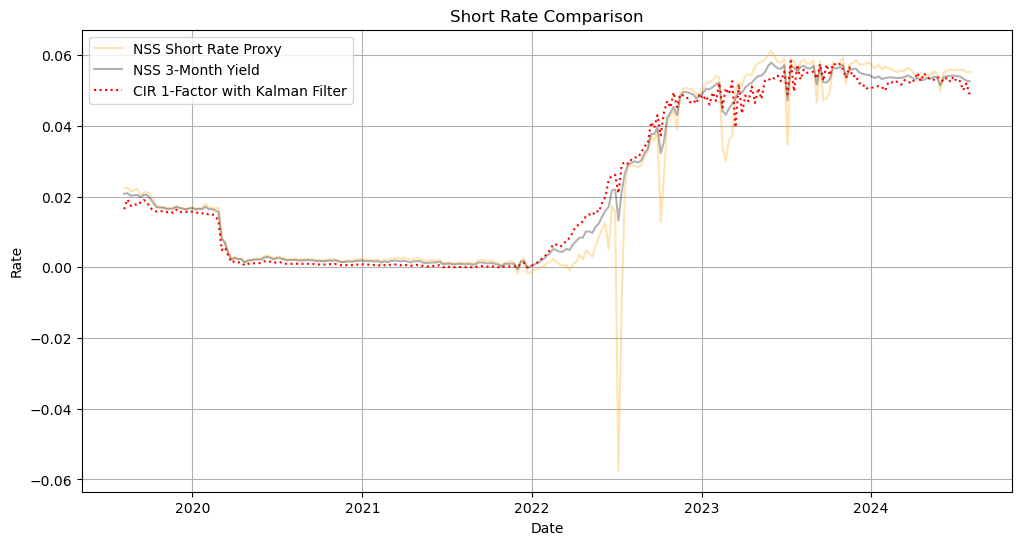

In [8]:
short_rate = sum([beta0, beta1])
short_rate

plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(df['Date'], short_rate, label='NSS Short Rate Proxy', color='orange', alpha=0.3)
plt.plot(df['Date'], yields_df['0.25y'],'-',label='NSS 3-Month Yield', color='black', alpha=0.3)
plt.plot(df['Date'], results['filtered_states'],':', label='CIR 1-Factor with Kalman Filter', color='red')
#plt.plot(df['Date'], smootjed_results['filtered_states'],':', label='CIR 1-Factor with Kalman Filter (Smoothed)', color='black')

plt.title('Short Rate Comparison')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
import pandas as pd

# Data
data = {
    "Maturity": ["0.25y", "0.5y", "1y", "3y", "5y", "10y", "30y"],
    "Mean": [0.0242, 0.0242, 0.0239, 0.0230, 0.0232, 0.0253, 0.0302],
    "Std Dev": [0.0229, 0.0223, 0.0211, 0.0175, 0.0154, 0.0133, 0.0109],
    "Q1": [0.0019, 0.0017, 0.0016, 0.0040, 0.0082, 0.0149, 0.0210],
    "Median": [0.0166, 0.0165, 0.0170, 0.0169, 0.0176, 0.0194, 0.0252],
    "Q3": [0.0521, 0.0508, 0.0473, 0.0412, 0.0392, 0.0383, 0.0403]
}

# Create DataFrame
descrip_stats = pd.DataFrame(data)
descrip_stats


,Maturity,Mean,Std Dev,Q1,Median,Q3
0,0.25y,0.0242,0.0229,0.0019,0.0166,0.0521
1,0.5y,0.0242,0.0223,0.0017,0.0165,0.0508
2,1y,0.0239,0.0211,0.0016,0.0170,0.0473
3,3y,0.0230,0.0175,0.0040,0.0169,0.0412
4,5y,0.0232,0.0154,0.0082,0.0176,0.0392
5,10y,0.0253,0.0133,0.0149,0.0194,0.0383
6,30y,0.0302,0.0109,0.0210,0.0252,0.0403


In [17]:
import pandas as pd
import numpy as np

# Convert filtered states to a DataFrame with the same index as yields_df
filtered_df = pd.DataFrame(
    np.tile(results['filtered_states'], (yields_df.shape[1], 1)).T,  # Repeat for each maturity
    index=yields_df.index, 
    columns=yields_df.columns
)

# Compute measurement errors
measurement_errors = yields_df - filtered_df

# Compute mean and variance for each maturity
error_summary = pd.DataFrame({
    'Mean Error': measurement_errors.mean(),
    'Variance Error': measurement_errors.var()
})

# Display results
error_summary

,Mean Error,Variance Error
0.25y,0.000431,0.000006
0.5y,0.000425,0.000002
1y,0.000091,0.000007
3y,-0.000828,0.000049
5y,-0.000592,0.000080
10y,0.001488,0.000119
30y,0.006429,0.000165
